# Title Here

Calvin Davis, Sabine May, Braden Nowicki, and Hudson Jones

## Introduction

- need to include motivation, brief description of data science pipeline, and overview on how we are applying that pipeline to our dataset(s)

Motivating article: https://www.birds.cornell.edu/home/bring-birds-back/#:~:text=NARRATOR%3A%20Birds%20are%20losing%20the,toxic%20pesticides%20and%20insect%20declines. 
- maybe specifically look at the common bird species that are mentioned in that article in the databases we analyze? 
- maybe look specifically at common bird specis in maryland? 
- red-winged blackbird mentioned in motivating article is common throughout the chespeake bay region: https://www.chesapeakebay.net/discover/field-guide/entry/red-winged-blackbird#:~:text=The%20red%2Dwinged%20blackbird%20is,dull%20brown%20with%20dark%20streaks. 
- Red-winged Blackbird AOU: 04980
- maybe want to correlate bird loss with excessive noise, relate to noise pollution in CP? 
- mayrland state num: 46
- Mass state num: 47

## Imports

Description of the libraries we're using/links to their tutorials and documentation

In [260]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import os

In [227]:
from os import walk

## Data Collection

### Reading the READMEs

In [82]:
# Unfortunately, our data is in downloadable .blah files, so we can't use scrape anything 
# automatically using Python's Requests library. Go to *link* and downloade following files: 
# *files*. Save them in your current directory under a folder called raw-date. Note that you will 
# need to expand the zip files *files*. Look through the files to get a feel for how the data is
# is formatted, and skim the README provided on the webiste. Here are some excerpts from that 
# readme that will be important for the data we actually want to process: 

# RPID = run protocol ID
# AOU = 5-digit special identification number, primary key in 50-stop data seems to be
# (RouteDataID, AOU) <- "Data identification number; unique for each combination of CountryNum, StateNum, Route, RPID, and Year"
# StopTotal = 
# SpeciesTotal = 
# Route = 3 digit code that identifies the route, unique within states 


# verify that we know what we're talking about here: 
# sum across frist row of fifty point total (alberta, state num: 04, route num: 6167164) with 
# corresponding total column in Alberta.csv (they are both 17, yay, but do it in code as well)

## Data Processing

### Cleaning Data on Bird Counts (Intervals)

In [328]:
# get all files in States directory (can't easily use formatting string because they are not numbered like the 50-states data)
filenames = next(walk("../Data/States"), (None, None, []))[2]  # [] if no file

# concat all the States files
interval_stop = pd.DataFrame()
for filename in filenames: 
    temp = pd.read_csv(f'../Data/States/{filename}')
    interval_stop = pd.concat([interval_stop, temp], ignore_index=True)

interval_stop_copy = interval_stop.copy()
interval_stop_copy.head(5)

,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Count10,Count20,Count30,Count40,Count50,StopTotal,SpeciesTotal
0,6170703,840,27,1,101,1970,1840,1,0,0,0,0,1,1
1,6170703,840,27,1,101,1970,1960,0,1,1,2,1,4,5
2,6170703,840,27,1,101,1970,2000,0,0,0,0,1,1,1
3,6170703,840,27,1,101,1970,2001,1,0,1,0,0,2,2
4,6170703,840,27,1,101,1970,2110,1,0,0,0,0,1,1


In [329]:
# get rid of anything that uses different sampling protocol (RPID)
# use RPID 101 - 104: Standard BBS Protocol: 3-minute counts, 1 observer, 
# single/second/third/fourth run per year. Average the counts accross runs? This makes sense 
# because the data is "collected annually during the breeding season, primarily in June" 
# so multiple runs should still be happening around the same time period. 
interval_stop_copy = interval_stop_copy[(interval_stop_copy['RPID'] >= 101) & (interval_stop_copy['RPID'] <= 104)]
interval_stop_copy = interval_stop_copy.groupby(['RouteDataID','CountryNum', 'StateNum', 'Route', 'Year', 'AOU']).agg({'Count10':['mean'], 'Count20':['mean'], 'Count30':['mean'], 'Count40':['mean'], 'Count50':['mean'], 'StopTotal':['mean'], 'SpeciesTotal':['mean']})

# flatten the multiindices in both the columns and rows
interval_stop_copy.columns = ['_'.join(col) for col in interval_stop_copy.columns.values]
interval_stop_copy.reset_index(inplace=True)

interval_stop_copy.head(5)

,RouteDataID,CountryNum,StateNum,Route,Year,AOU,Count10_mean,Count20_mean,Count30_mean,Count40_mean,Count50_mean,StopTotal_mean,SpeciesTotal_mean
0,6165530,840,52,32,1968,2610,0.0,0.0,3.0,0.0,4.0,6.0,7.0
1,6165530,840,52,32,1968,2730,0.0,0.0,3.0,0.0,0.0,1.0,3.0
2,6165530,840,52,32,1968,2890,15.0,8.0,14.0,11.0,7.0,32.0,55.0
3,6165530,840,52,32,1968,3131,0.0,1.0,0.0,1.0,0.0,2.0,2.0
4,6165530,840,52,32,1968,3160,14.0,11.0,17.0,9.0,9.0,34.0,60.0


In [330]:
interval_stop_copy = interval_stop_copy.groupby(['RouteDataID','CountryNum', 'StateNum', 'Route', 'Year']).agg({'Count10_mean':['sum'], 'Count20_mean':['sum'], 'Count30_mean':['sum'], 'Count40_mean':['sum'], 'Count50_mean':['sum'], 'StopTotal_mean':['sum'], 'SpeciesTotal_mean':['sum']})

# flatten the multiindices in both the columns and rows
interval_stop_copy.columns = ['_'.join(col) for col in interval_stop_copy.columns.values]
interval_stop_copy.reset_index(inplace=True)

interval_stop_copy.columns = ['RouteDataID', 'CountryNum', 'StateNum', 'Route', 'Year', 'Count10_MS', 'Count20_MS', 'Count30_MS', 'Count40_MS', 'Count50_MS', 'StopTotal_MS', 'SpeciesTotal_MS']
interval_stop_copy.head(5)

,RouteDataID,CountryNum,StateNum,Route,Year,Count10_MS,Count20_MS,Count30_MS,Count40_MS,Count50_MS,StopTotal_MS,SpeciesTotal_MS
0,6165530,840,52,32,1968,182.0,207.0,191.0,191.0,194.0,481.0,965.0
1,6165531,840,52,35,1968,159.0,139.0,132.0,135.0,116.0,354.0,681.0
2,6165532,840,52,36,1968,193.0,225.0,170.0,160.0,162.0,584.0,910.0
3,6165533,840,53,5,1968,84.0,97.0,96.0,114.0,210.0,188.0,601.0
4,6165534,840,53,2,1968,95.0,76.0,76.0,88.0,91.0,283.0,426.0


In [331]:
current_dir = os.getcwd()
interval_stop_copy.to_csv(os.path.join(current_dir, '..', 'SharedData', 'Interval_Aggs_All_Routes.csv'), index=False)

### Cleaning Data on Vehicle Counts and Bird Counts (All Stops)

In [394]:
vehicles = pd.read_csv("../Data/VehicleData.csv") # Discuss what the Noise columns mean, and why we aren't doing missing value imputation on bird counts based on Noise.
vehicles.head(5)

,RouteDataID,CountryNum,StateNum,Route,RPID,Year,RecordedCar,Car1,Car2,Car3,...,Noise41,Noise42,Noise43,Noise44,Noise45,Noise46,Noise47,Noise48,Noise49,Noise50
0,6167164,124,4,1,101,2000,NaN,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6248812,124,4,1,101,2005,1.0,3,4,5,...,0,0,0,0,0,0,0,0,0,0
2,6297584,124,4,1,101,2006,NaN,5,5,4,...,0,0,0,0,0,0,0,0,0,0
3,6297586,124,4,1,101,2007,NaN,4,4,2,...,0,0,0,0,0,0,0,0,0,0
4,6358333,124,4,1,101,2015,1.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [395]:
# note that this isn't recorded for every route, otherwise it would have the same length as our cleaned interval_stop_copy dataframe
# (because interval_stop_copy aggregated over all species, and vehicles does not seperate observations by number of species)
print(f"Number of routes where vehicle observations were taken: {len(vehicles)}")
print(f"Number of routes: {len(interval_stop_copy)}")

# get rid of anything that's not certain (NaNs in RecordedCards or 0s in RecordedCar)
# the .drop() is an alternative to vehciles = vehicles[vehicles['RecordedCar' == 1]] 
# don't chain fillna() and drop() or it won't drop newly-changed zero values 
vehicles.fillna(0, inplace=True)
vehicles.drop(vehicles[vehicles['RecordedCar'] == 0].index, inplace=True)
vehicles.reset_index(drop = True, inplace=True)
vehicles.drop(vehicles.columns[vehicles.columns.get_loc('Noise1'):], axis=1, inplace=True)

vehicles = vehicles[(vehicles['RPID'] >= 101) & (vehicles['RPID'] <= 104)]

car_dict = {}
for x in range(1, 51):
    car_dict[f'Car{x}'] = ['mean']

vehicles = vehicles.groupby(['RouteDataID','CountryNum', 'StateNum', 'Route', 'Year', 'RecordedCar']).agg(car_dict)

# flatten the multiindices in both the columns and rows
vehicles.columns = ['_'.join(col) for col in vehicles.columns.values]
vehicles.reset_index(inplace=True)

cars = []
past_cars = []

for x in range(1, 51, 10):
    for y in range(x, x+10):
        cars.append(f'Car{y}_mean')
        past_cars.append(f'Car{y}_mean')

    vehicles[f'Car_Count{y}'] = vehicles[cars].sum(axis = 1)
    cars = []

vehicles['Car_Total'] = vehicles[past_cars].sum(axis=1)

vehicles.head(5)

Number of routes where vehicle observations were taken: 76514
Number of routes: 135192


,RouteDataID,CountryNum,StateNum,Route,Year,RecordedCar,Car1_mean,Car2_mean,Car3_mean,Car4_mean,...,Car47_mean,Car48_mean,Car49_mean,Car50_mean,Car_Count10,Car_Count20,Car_Count30,Car_Count40,Car_Count50,Car_Total
0,6165782,840,34,36,2003,1.0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,4.0,5.0,15.0,7.0,0.0,31.0
1,6165783,840,34,38,2003,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,6.0,0.0,0.0,2.0,6.0,3.0,16.0,27.0
2,6165785,840,34,40,2003,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2.0,4.0,11.0,97.0,11.0,14.0,40.0,173.0
3,6165786,840,34,44,2003,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,5.0,1.0,1.0,2.0,5.0,14.0
4,6165787,840,34,42,2003,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,3.0,28.0,15.0,23.0,12.0,81.0


In [334]:
# concat all the fifty csv files 
fifty_stop = pd.DataFrame()
for x in range(1,11):
    temp = pd.read_csv(f'../Data/50-StopData/fifty{x}.csv')
    fifty_stop = pd.concat([fifty_stop, temp], ignore_index=True)

In [396]:
fifty_stop_copy = fifty_stop.copy()
fifty_stop_copy.head(5)

,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Stop1,Stop2,Stop3,...,Stop41,Stop42,Stop43,Stop44,Stop45,Stop46,Stop47,Stop48,Stop49,Stop50
0,6167164,124,4,1,101,2000,530,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6167164,124,4,1,101,2000,534,20,10,14,...,0,0,0,0,0,0,0,0,0,0
2,6167164,124,4,1,101,2000,540,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,6167164,124,4,1,101,2000,590,0,16,0,...,0,0,0,0,0,0,0,0,0,0
4,6167164,124,4,1,101,2000,1200,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [397]:
fifty_stop_copy = fifty_stop_copy[(fifty_stop_copy['RPID'] >= 101) & (fifty_stop_copy['RPID'] <= 104)]

stop_dict = {}
for x in range(1, 51):
    stop_dict[f"Stop{x}"] = ['mean']

fifty_stop_copy = fifty_stop_copy.groupby(['RouteDataID','CountryNum', 'StateNum', 'Route', 'Year', 'AOU']).agg(stop_dict)

# flatten the multiindices in both the columns and rows
fifty_stop_copy.columns = ['_'.join(col) for col in fifty_stop_copy.columns.values]
fifty_stop_copy.reset_index(inplace=True)

stop_dict = {}
for x in range(1, 51):
    stop_dict[f"Stop{x}_mean"] = ['sum']

fifty_stop_copy = fifty_stop_copy.groupby(['RouteDataID','CountryNum', 'StateNum', 'Route', 'Year']).agg(stop_dict)

# flatten the multiindices in both the columns and rows
fifty_stop_copy.columns = ['_'.join(col) for col in fifty_stop_copy.columns.values]
fifty_stop_copy.reset_index(inplace=True)

cols = ['RouteDataID', 'CountryNum', 'StateNum', 'Route', 'Year']
for x in range(1, 51):
    cols.append(f'Stop{x}_MS')

fifty_stop_copy.columns = cols
fifty_stop_copy.head(5)

# Baltimore Oriole: 05070

,RouteDataID,CountryNum,StateNum,Route,Year,Stop1_MS,Stop2_MS,Stop3_MS,Stop4_MS,Stop5_MS,...,Stop41_MS,Stop42_MS,Stop43_MS,Stop44_MS,Stop45_MS,Stop46_MS,Stop47_MS,Stop48_MS,Stop49_MS,Stop50_MS
0,6165782,840,34,36,2003,20.0,18.0,17.0,14.0,17.0,...,21.0,2.0,3.0,5.0,2.0,15.0,4.0,7.0,11.0,5.0
1,6165783,840,34,38,2003,10.0,10.0,12.0,15.0,15.0,...,9.0,14.0,19.0,20.0,7.0,11.0,14.0,13.0,15.0,15.0
2,6165784,840,34,39,2003,15.0,14.0,13.0,10.0,9.0,...,17.0,35.0,21.0,17.0,14.0,11.0,15.0,11.0,12.0,45.0
3,6165785,840,34,40,2003,11.0,259.0,29.0,41.0,65.0,...,13.0,11.0,15.0,15.0,13.0,9.0,10.0,18.0,22.0,17.0
4,6165786,840,34,44,2003,27.0,19.0,39.0,29.0,28.0,...,21.0,78.0,44.0,14.0,26.0,8.0,19.0,25.0,27.0,27.0


In [337]:
fifty_stop_copy = fifty_stop_copy.merge(vehicles, how='inner', on=['RouteDataID', 'CountryNum', 'StateNum', 'Route', 'Year']) # added Route and Year even though RouteDataID is enough b/c didn't want Year_x
fifty_stop_copy.head(5)

,RouteDataID,CountryNum,StateNum,Route,Year,Stop1_MS,Stop2_MS,Stop3_MS,Stop4_MS,Stop5_MS,...,Car41_mean,Car42_mean,Car43_mean,Car44_mean,Car45_mean,Car46_mean,Car47_mean,Car48_mean,Car49_mean,Car50_mean
0,6165782,840,34,36,2003,20.0,18.0,17.0,14.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6165783,840,34,38,2003,10.0,10.0,12.0,15.0,15.0,...,0.0,1.0,0.0,6.0,0.0,2.0,0.0,1.0,6.0,0.0
2,6165785,840,34,40,2003,11.0,259.0,29.0,41.0,65.0,...,16.0,12.0,1.0,2.0,1.0,0.0,2.0,0.0,2.0,4.0
3,6165786,840,34,44,2003,27.0,19.0,39.0,29.0,28.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0
4,6165787,840,34,42,2003,7.0,10.0,10.0,10.0,15.0,...,2.0,1.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0


In [341]:
fifty_stop_md = fifty_stop_copy[(fifty_stop_copy['CountryNum'] == 840) & (fifty_stop_copy['StateNum'] == 46)].reset_index(drop=True)
interval_stop_md = interval_stop_copy[(interval_stop_copy['CountryNum'] == 840) & (interval_stop_copy['StateNum'] == 46)]

In [356]:
interval_stop_copy[['Year', 'SpeciesTotal_MS']].head(5)

,Year,SpeciesTotal_MS
0,1968,965.0
1,1968,681.0
2,1968,910.0
3,1968,601.0
4,1968,426.0


In [400]:
intervals_vehicles = interval_stop_copy.merge(vehicles, how='inner', on=['RouteDataID', 'CountryNum', 'StateNum', 'Route', 'Year']) # added Route and Year even though RouteDataID is enough b/c didn't want Year_x
intervals_vehicles.head(5)

,RouteDataID,CountryNum,StateNum,Route,Year,Count10_MS,Count20_MS,Count30_MS,Count40_MS,Count50_MS,...,Car47_mean,Car48_mean,Car49_mean,Car50_mean,Car_Count10,Car_Count20,Car_Count30,Car_Count40,Car_Count50,Car_Total
0,6165782,840,34,36,2003,170.0,192.0,204.0,138.0,75.0,...,0.0,0.0,0.0,0.0,4.0,5.0,15.0,7.0,0.0,31.0
1,6165783,840,34,38,2003,132.0,252.0,216.0,247.0,137.0,...,0.0,1.0,6.0,0.0,0.0,2.0,6.0,3.0,16.0,27.0
2,6165785,840,34,40,2003,479.0,236.0,218.0,219.0,143.0,...,2.0,0.0,2.0,4.0,11.0,97.0,11.0,14.0,40.0,173.0
3,6165786,840,34,44,2003,314.0,295.0,308.0,233.0,289.0,...,0.0,0.0,0.0,3.0,5.0,1.0,1.0,2.0,5.0,14.0
4,6165787,840,34,42,2003,112.0,107.0,137.0,148.0,103.0,...,0.0,0.0,1.0,0.0,3.0,28.0,15.0,23.0,12.0,81.0


## Exploratory Analysis and Data Visualization

In [358]:
# interval_stop_copy -- mean of protocol, sum of species. Not grouped on year
# fifty_stop_copy -- mean of protocol, sum of species. Not grouped on year
# interval_stop_md -- idem but with maryland
# fifty_stop_md -- idem but with maryland

birds_by_year = interval_stop_copy[['Year', 'SpeciesTotal_MS']].groupby(['Year'])
birds_by_year = birds_by_year.agg({'SpeciesTotal_MS' : ['sum']})

# flatten the multiindices in both the columns and rows
birds_by_year.columns = ['_'.join(col) for col in birds_by_year.columns.values]
birds_by_year.reset_index(inplace=True)

birds_by_year.columns = ['Year', 'SpeciesTotal']
birds_by_year.head(5)

,Year,SpeciesTotal
0,1966,483377.0
1,1967,832503.0
2,1968,986836.0
3,1969,1128240.0
4,1970,1214436.0


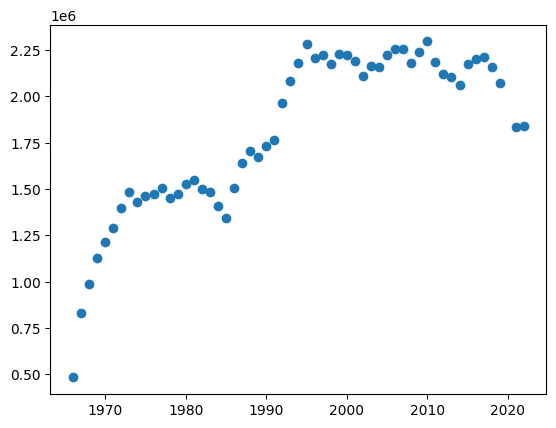

In [359]:
plt.scatter(birds_by_year['Year'], birds_by_year['SpeciesTotal'])

In [365]:
birds_by_year = interval_stop_copy[['Year', 'SpeciesTotal_MS']].groupby(['Year'])
count = birds_by_year.size()

birds_by_year = birds_by_year.agg({'SpeciesTotal_MS' : ['sum']})

# flatten the multiindices in both the columns and rows
birds_by_year.columns = ['_'.join(col) for col in birds_by_year.columns.values]
birds_by_year.reset_index(inplace=True)

birds_by_year.columns = ['Year', 'SpeciesTotal_MS']
count.index = birds_by_year.index
birds_by_year['BirdsPerRoute'] = birds_by_year['SpeciesTotal_MS'] / count
birds_by_year.head(5)

,Year,SpeciesTotal_MS,BirdsPerRoute
0,1966,483377.0,906.898687
1,1967,832503.0,882.823966
2,1968,986836.0,832.070826
3,1969,1128240.0,844.491018
4,1970,1214436.0,848.662474


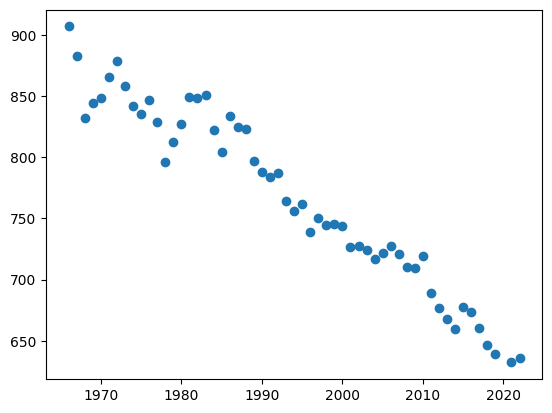

In [366]:
plt.scatter(birds_by_year['Year'], birds_by_year['BirdsPerRoute'])

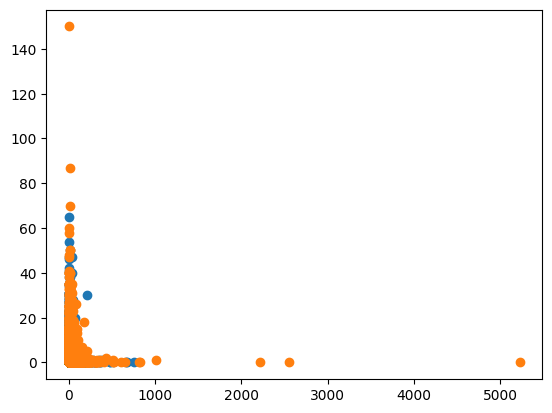

In [381]:
plt.scatter(fifty_stop_copy['Stop2_MS'], fifty_stop_copy['Car2_mean'])
plt.scatter(fifty_stop_copy['Stop3_MS'], fifty_stop_copy['Car3_mean'])


## Hypothesis Testing and Machine Learning